In [12]:
import numpy as np 
from math import pi as π
import matplotlib.pyplot as plt
from bosons import (
    construct_basis,
    move_excitation_operator,
    diagonals_with_energies,
    concatenate_bases,
    erase,
)
from waveguide import Waveguide
from simulator import Trotter_solver_dynamics
from architecture import Exp_2qubits_2cavities_2purcells
%matplotlib widget

If we considered a system consisting of just an emitter, a resonator and a decay channel, i.e.,
\begin{align}
    \dot{q}(t)&=-i g(t) c(t)\\
    \dot{c}(t)&=-i g(t) q(t)-\frac{\kappa}{2}c(t),
\end{align}
and wanted to produce a wavepacket of the form 
\begin{align}
    \psi(t)=-\sqrt{\kappa/4}{\rm sech}(\kappa t/2),
\end{align}
we would obtain the following time dependent control by reverse-engineering the equations:


$$ g(t) = \frac{\kappa}{2} \text{sech}\left(\kappa t /2\right) $$

In [11]:
def gt_sech(t, κ = 2*π*20e-3 ):
    
    return κ / 2 / np.cosh(κ*t/2)

If instead one considers that there is a Purcell filter in between the resonator and the waveguide as it is the case in the ETH setup
\begin{align}
    \dot{q}(t)&=-ig(t) c(t)\\
    \dot{c}(t)&=-ig(t) q(t) -ig_p b(t)\\
    \dot{b}(t)&=-ig_p c(t)-\kappa/2 b(t),
\end{align}
what one would find for the same proposed photon is the following control:

\begin{align}
    g(t)=\frac{{\rm sech}^3(\kappa t/(2\eta))\left(4g_p^2\eta^2-3\kappa^2+(4g_p^2\eta^2+\kappa^2)\cosh(\kappa t/\eta)-\eta\kappa^2\sinh(\kappa t/\eta) \right)}{4\eta\left(\kappa^2{\rm sech}^4(\kappa t/(2\eta))-8 g_p^2\eta^3(\tanh(\kappa t/(2\eta))-1)-{\rm sech}^2(\kappa t/(2\eta))\left(\kappa^2+\eta^2(4g_p^2+\kappa^2)-2\eta\kappa^2\tanh(\kappa t/(2\eta)) \right)\right)^{1/2}}.
\end{align}

In [6]:
def gt(t, κ = 2*π*20e-3, η = 6.76, g_p = 2*π*25e-3):
        
    return (((1/np.cosh( κ*t/(2*η) ))**3) * ( 4*g_p**2 * η**2 - 3*κ**2 + (4*g_p**2 * η**2 + κ**2) * np.cosh( κ*t/η ) - η*κ**2 * np.sinh( κ*t/η)))/ \
    (4*η*(κ**2 * ((1/np.cosh( κ*t/(2*η) ))**4) - 8*g_p**2 * η**3 * (np.tanh( κ*t/(2*η) )-1)  -  ((1/np.cosh( κ*t/(2*η) ))**2) * (κ**2 + η**2 * (4*g_p**2 + κ**2) - 2*η*κ**2 * np.tanh( κ*t/(2*η) ) ))**0.5)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


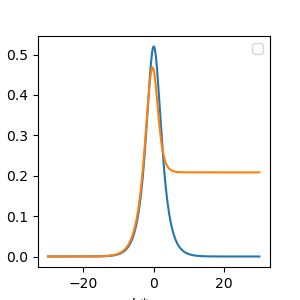

In [10]:
fig, (ax) = plt.subplots(nrows=1, figsize=(3,3), sharex=True)

κ_eff = 2*π*130e-3/6.76
t = np.linspace(-30/κ_eff, 30/κ_eff, 1000)


ax.plot(t*κ_eff, gt_sech(t)/κ_eff )
ax.plot(t*κ_eff, gt(t, κ = 2*π*130e-3)/κ_eff )

ax.set_xlabel('t * $\kappa_{eff}$')
ax.set_ylabel('$gt / \kappa_{eff}$')

ax.legend()
plt.show()


In [35]:

def state_transfer(gt, lamb_shift=1, δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913,  g_p=2*π*25e-3,
                    kappa=2*π*20e-3, η = 1,
                   Tfp=10, Nt=3000, length=30, modes=2101, Nexcitations = 1, tdelay = None,
                   quiet=False, filename=None):

  
    WG =  Waveguide( frequency= ω1+lamb_shift, modes = modes, length = length )
    print(WG.tprop)
    
    ## solve dynamics
    
    κ_eff = 4 * g_p**2 / kappa
    
    if tdelay is None:
        
        tdelay = 1*WG.tprop #separation between protocol g_1(t) and g_2(t) /time reversed. 
    
    else:
        tdelay = tdelay
    
    duration = tdelay + 2 * Tfp*(η/kappa)
    time = np.linspace(-duration/2, duration/2, Nt)
    
        
    def g1t(t):
        return gt(t + tdelay/2)

    def g2t(t):
        return gt(tdelay/2 - t)


    control = Exp_2qubits_2cavities_2purcells(δ1 = δ1, δ2 = δ2, ω1 = ω1, ω2 = ω2, g1=g1t, g2=g2t,  
                                                 gp1=g_p, gp2=g_p, κ1=kappa, κ2=kappa, δLamb = lamb_shift,
                                                 waveguide = WG, Nexcitations = Nexcitations)

    print('Lamb_shift=',control.E[0]- control.δ1)
    print('Frequency of qubit 1=',control.E[0])


    #Control initial/final values:
    print(f'Initial value of the control g_1(-tf)= (2π)*{g1t(time[0]-tdelay/2)/2/π*1e3}MHz')
    print(f'Initial value of the control g_1(-tf)= (2π)*{gt(time[0])/2/π*1e3}MHz')
    print('kappa= (2π)',kappa/2/π*1e3,'MHz')    
    print('η=', η)
    print('g_p= (2π)', g_p/2/π*1e3,'MHz')
    print(f'Total time ={duration/WG.tprop}*Propagation_time')


    vt = Trotter_solver_dynamics(time, control.qubit_excited(which=0), control.Hamiltonian )
    P = np.abs(vt)**2
    ## Showing results:
    
    Pwaveguide = np.sum(P[6:,:],0)
    print(f'|q_1(tf)|^2 = {P[0,-1]}\n'
          f'|c_1(tf)|^2 = {P[2,-1]}\n'
          f'|filter_1(tf)|^2 = {P[4,-1]}\n'
          f'|wv(tf)|^2  = {Pwaveguide[-1]} (max = {max(Pwaveguide)})\n'
          f'|filter_2(tf)|^2 = {P[5,-1]}\n'
          f'|c_2(tf)|^2 = {P[3,-1]}\n'
          f'|q_2(tf)|^2 = {P[1,-1]}\n'
          f' 1-F        = {1-P[1,-1]}')
    if not quiet:
        fig, (ax, axc) = plt.subplots(nrows=2, figsize=(10,8), sharex=True)
        ax.plot(time*kappa, P[0,:], label='qubit 1')
        ax.plot(time*kappa, P[2,:], '--', label='cavity 1')
        ax.plot(time*kappa, P[4,:], '--', label='Purcell 1')

        ax.plot(time*kappa, Pwaveguide, '-.', label='waveguide')
        
        ax.plot(time*kappa, P[5,:], '--', label='Purcell 2')
        ax.plot(time*kappa, P[3,:], '--', label='cavity 2')
        ax.plot(time*kappa, P[1,:], label='qubit 2')


        #ax.set_xlabel(r'$t\kappa$')
        ax.legend(fontsize=16)
        ax.set_title(f'$l={length}\,m,\,'
                     r'\omega=2\pi\times'
                     f'{control.ω1/(2*π)}'
                     r'\,\mathrm{GHz},\,\kappa_filter=2\pi\times'
                     f'{np.round(kappa/(2e-3*π))}'
                     r'\,\mathrm{MHz},\,\kappa_{eff}='
                     f'{np.round(kappa/(2e-3*π)/η,3)}$', fontsize=16)
        axc.plot(time*kappa, g1t(time)/kappa/η, label=r'$g_1(t)/\kapp_secha_1$')
        axc.plot(time*kappa, g2t(time)/kappa/η, label=r'$g_2(t)/\kappa_2$')
        axc.set_xlabel(r'$t\kappa_1$')
        axc.set_ylabel(r'$g_i(t)/\kappa_i$')
        axc.legend(fontsize=16)
        fig.tight_layout()
        plt.show()
        if filename:
            fig.savefig(filename)
    
    timeres = time/WG.tprop
    q1end = P[0,-1]
    q2end = P[1,-1]
    return q2end, q1end, vt, duration, time, timeres, WG.frequencies

## Control derived from qubit-cavity-filter.

In [21]:
q2end = []
Protocol_time = []
for i in np.linspace(1, 16, 15):
    
    q2end_i, _, _, Protocol_time_i, _, _,_ = state_transfer(gt, lamb_shift= (0.0229) * (2*π)*19.231e-3, δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, g_p=2*π*25e-3,
                   kappa=2*π*130e-3, η=6.76,
                   Tfp=i, Nt=3000, length=30, modes=2101,
                   quiet=True, filename=None)
    
    q2end.append(q2end_i)
    Protocol_time.append(Protocol_time_i)

159.89864162161894
Lamb_shift= 0.002767051349110261
Frequency of qubit 1= 52.82562741720627
Initial value of the control g_1(-tf)= (2π)*0.10002666519348298MHz
Initial value of the control g_1(-tf)= (2π)*0.10002666519348281MHz
kappa= (2π) 130.0 MHz
η= 6.76
g_p= (2π) 25.0 MHz
Total time =1.1035162895299993*Propagation_time
|q_1(tf)|^2 = 0.00239888893518281
|c_1(tf)|^2 = 0.0006249798899616779
|filter_1(tf)|^2 = 9.823005043872496e-05
|wv(tf)|^2  = 0.8199495214478962 (max = 0.9952669057131133)
|filter_2(tf)|^2 = 0.0652147425290999
|c_2(tf)|^2 = 0.10349106361154768
|q_2(tf)|^2 = 0.008222573535736539
 1-F        = 0.9917774264642635
159.89864162161894
Lamb_shift= 0.002767051349110261
Frequency of qubit 1= 52.82562741720627
Initial value of the control g_1(-tf)= (2π)*0.058541844175215914MHz
Initial value of the control g_1(-tf)= (2π)*0.058541844175215914MHz
kappa= (2π) 130.0 MHz
η= 6.76
g_p= (2π) 25.0 MHz
Total time =1.214426599740713*Propagation_time
|q_1(tf)|^2 = 0.00029420016779918866
|c_1(

## Sech control. Derived from qubit-cavity.

In [37]:
q2end_sech = []
Protocol_time = []
for i in np.linspace(1, 16, 15):
    
    q2end_i_sech, _, _, Protocol_time_i_sech, _, _,_ = state_transfer(gt_sech, lamb_shift= (0.0229) * (2*π)*19.231e-3, δ1=2*π*8.40701933547913, δ2=2*π*8.40701933547913,
                   ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, g_p=2*π*25e-3,
                   kappa=2*π*130e-3, η=6.76,
                   Tfp=i, Nt=3000, length=30, modes=2101,
                   quiet=True, filename=None)
    q2end_sech.append(q2end_i_sech)
    Protocol_time.append(Protocol_time_i_sech)

159.89864162161894
Lamb_shift= 0.002767051349110261
Frequency of qubit 1= 52.82562741720627
Initial value of the control g_1(-tf)= (2π)*0.0782656070027163MHz
Initial value of the control g_1(-tf)= (2π)*0.07826560700271623MHz
kappa= (2π) 130.0 MHz
η= 6.76
g_p= (2π) 25.0 MHz
Total time =1.1035162895299993*Propagation_time
|q_1(tf)|^2 = 0.047560329817862075
|c_1(tf)|^2 = 6.889412943463618e-09
|filter_1(tf)|^2 = 9.450942870210775e-10
|wv(tf)|^2  = 0.7453047161357023 (max = 0.9524395116347002)
|filter_2(tf)|^2 = 0.07840224687617657
|c_2(tf)|^2 = 0.11807325813035388
|q_2(tf)|^2 = 0.010659441205270105
 1-F        = 0.9893405587947299
159.89864162161894
Lamb_shift= 0.002767051349110261
Frequency of qubit 1= 52.82562741720627
Initial value of the control g_1(-tf)= (2π)*0.04483439954089384MHz
Initial value of the control g_1(-tf)= (2π)*0.04483439954089384MHz
kappa= (2π) 130.0 MHz
η= 6.76
g_p= (2π) 25.0 MHz
Total time =1.214426599740713*Propagation_time
|q_1(tf)|^2 = 0.004266369471505334
|c_1(tf)

## Plotting the results

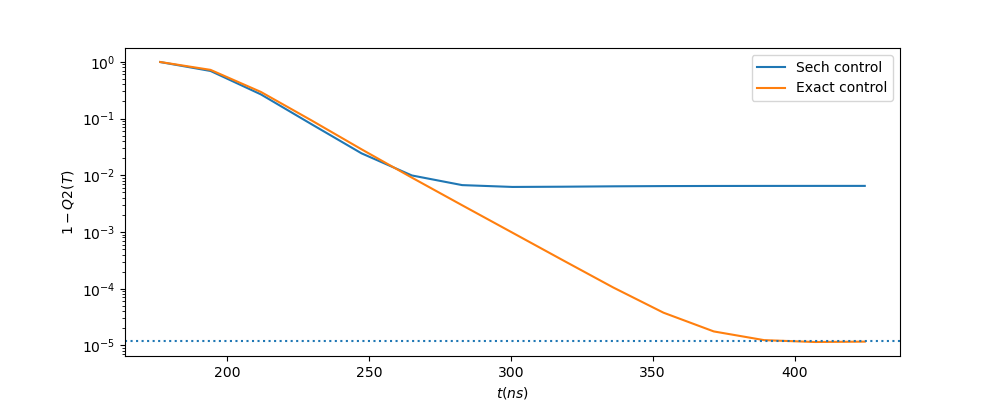

In [41]:
fig, (ax) = plt.subplots(nrows=1, figsize=(10,4), sharex=True)
ax.plot(np.array(Protocol_time), 1-np.array(q2end_sech), label = 'Sech control')
ax.plot(np.array(Protocol_time), 1-np.array(q2end), label = 'Exact control')
#ax.plot(np.array(Protocol_time_resonant_dressed), 1-np.array(q2end_resonant_dressed), label = 'Exact control dressed')

ax.semilogy()
ax.axhline(y=1.2e-5, linestyle = ':')
ax.legend()
ax.set_xlabel('$t(ns)$')
ax.set_ylabel('$1-Q2(T)$')

plt.show()